In [ ]:
!pip install langchain_fireworks
!pip install datasets
!pip install dotenv
!pip install python-dotenv

In [ ]:
!pip install evaluate

In [ ]:
!mv /content/.env /content/env.txt

mv: cannot stat '/content/.env': No such file or directory


In [16]:
import requests
import os
import json
from dotenv import  load_dotenv
load_dotenv()

True

In [17]:
API_KEY = os.environ.get('FIREWORKS_API_KEY')

In [ ]:
!ls -a /content/

.  ..  .config	.env  .ipynb_checkpoints  sample_data


# Language Model Distillation

<img src="https://arxiv.org/html/2402.13116v3/x2.png" width=600>

Model Distillation is the process of using a large foundation model/high parameter LLMs to create annotated data for a specific task. That data is then used to fine tune a lightweight language model on the same task, allowing the smaller parameter model to perform as well as the foundation model at a fraction of the cost, energy consumption, and time.

Per the paper [A Survey on Knowledge Distillation of Large Language Models](https://arxiv.org/pdf/2402.13116), "This process is akin to transferring the ‘knowledge’ of a highly skilled teacher to a student, wherein the student (e.g., open-source LLM) learns to mimic the performance characteristics of the teacher (e.g., proprietary LLM)."

Most tasks that LLMs are applied to don't utilize the entire capability and power of a full size foundation model, so *why not distill down your one specific application into its own model?*

**In this notebook we'll be:**
1. Using [Llama 3.1 405B](https://huggingface.co/meta-llama/Meta-Llama-3.1-405B) to classify the sentiment of tweets, and
2. Using Deepseek-V3 671B (671 billion parameters) to classify the sentiment of tweets, and
3. Use that dataset to train [Roberta-base](https://huggingface.co/FacebookAI/roberta-base) a 125 million parameter language model.

We end up with a model that performs with the same accuracy, at 0.03% of the size!

---
# Teacher Model Data Annotation

Dataset consists of tweets with labeled sentiments, [mteb/tweet_sentiment_extraction](https://huggingface.co/datasets/mteb/tweet_sentiment_extraction). We will be using the tweet texts along with prompting to generate the "knowledge" annotation. This data is what becomes the training data for distillation.

This would become simply fine-tuning/model training if the data is not generated by an LLM teacher! (i.e. human annotated data)

For the sake of demonstration, assuming this data is not annoted already.

### Importing Existing Dataset

In [ ]:
from datasets import load_dataset

ds = load_dataset("mteb/tweet_sentiment_extraction")

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})

In [ ]:
ds['train'][0]

{'id': 'cb774db0d1',
 'text': ' I`d have responded, if I were going',
 'label': 1,
 'label_text': 'neutral'}

### Creating CSV

Converting a subset to a local csv for easy manipulation and sampling.

In [ ]:
# Convert train dataset to pandas DataFrame
train_df = ds["train"].to_pandas()

# Convert test dataset to pandas DataFrame
test_df = ds["test"].to_pandas()

### Cleaning the CSV

Simple script for dropping blank values that may break processing later on

In [ ]:
# Remove rows where the 'text' column is blank or NaN
df_cleaned = train_df[train_df['text'].notna() & (train_df['text'].str.strip() != '')]


### Data Splitting for Training and Testing
This code splits the cleaned dataset (df_cleaned) into three parts:

1. Training Data: The first 5000 rows are selected for training (train_df_final).
2. Testing Data: The next 1000 rows (5000-5999) are used for testing (test_df_final).
3. Complete Dataset: The first 6000 rows are combined as the full dataset (df_complete).
These datasets are saved as CSV files (train.csv, test.csv, df_complete.csv) for model training, evaluation, and further analysis.

#### Note: We are using only 6000 records for this experiment due to API cost constraints.

In [ ]:
### for our project we are going to use first 5000 for trainng dataset :

train_df_final = df_cleaned.iloc[:4999,:]
test_df_final = df_cleaned.iloc[5000:5999,:]

train_df_final.to_csv('/content/train.csv')
test_df_final.to_csv('/content/test.csv')

df_complete = df_cleaned.iloc[:5999,:]
df_complete.to_csv('/content/df_complete.csv')

---
# Setting Up Teacher LLM

[Llama 3.1 405B](https://ai.meta.com/blog/meta-llama-3-1/) explicitly states that *Our new model will enable the community to unlock new workflows, such as synthetic data generation and model distillation* in Meta's [release blog](https://ai.meta.com/blog/meta-llama-3-1/), so I wanted to use it as an example for distillation on this task, thus Llama 3.1 405B becomes the teacher model.

The cheapest inference API i could find is via [Fireworks.ai](https://fireworks.ai/) which, at the time of making this, offer 1M Token `Input/Output` at `$3/$3` respectively. We'll use their integration with LangChain to instantiate.

[DeepSeek V3](https://github.com/deepseek-ai/DeepSeek-V3?utm_source=chatgpt.com) is a Mixture-of-Experts (MoE) language model with 671 billion parameters, activating 37 billion for each token during inference. It achieves state-of-the-art performance across various benchmarks, including mathematics, coding, and multilingual tasks. 
GITHUB.COM

The DeepSeek V3 API offers the following pricing:

1. Input (cache miss): $0.27 per million tokens
2. Input (cache hit): $0.07 per million tokens
3. Output: $1.10 per million tokens


To integrate DeepSeek V3 into your project, you can use the DeepSeek API. Detailed documentation and access to the API are available on their official website. 
(https://fireworks.ai/?utm_source=chatgpt.com)

By leveraging DeepSeek V3, you can utilize a powerful language model for tasks such as synthetic data generation and model distillation, enabling efficient and cost-effective AI workflows.

For seamless integration with LangChain, you can utilize the Fireworks AI integration. This allows you to instantiate the model and perform inference tasks efficiently. 


By leveraging DeepSeek V3, you can utilize a powerful language model for tasks such as synthetic data generation and model distillation, enabling efficient and cost-effective AI workflows.

In [18]:
from langchain_fireworks import ChatFireworks

deepseek_v3 = ChatFireworks(
    model="accounts/fireworks/models/deepseek-v3",
    temperature=0.7
)

### Prompting

To ensure we give our teacher model the best opportunity, we'll be employing two techniques in our classification prompt:
1. **Chain-of-Thought Reasoning:** Making the language model write a reasoning description to "think" through the problem before giving an answer
2. **Few-shot Prompting:** Providing robust examples about your expectations of both performance and format to better guide the LLM.

Examples taken from entries within the rows 7101-7200, which will not be used during training or for testing further on

In [19]:
tweet_sentiment_cot_prompt = """\
You are a highly qualified expert trained to annotate machine learning training data.
Your task is to briefly analyze the sentiment in the TEXT below from an social media manager perspective and then label it with only one the three labels:
positive, negative, neutral.
Base your label decision only on the TEXT and do not speculate e.g. based on prior knowledge about the context.
You first reason step by step about the correct label and then return your label.
You ALWAYS respond once in the following JSON format with brackets: {{"reason": "...", "label": "..."}}

Examples:
Text: Mode: Home Office
JSON: {{"reason": "The text is a factual statement about a work mode without expressing any emotion or opinion", "label": "neutral"}}
Text: oh oh oh are you offering to send ducks! I love love love confit duck
JSON: {{"reason": "The text expresses enthusiasm and love for confit duck, indicating a positive sentiment", "label": "positive"}}
Text: off to glue stuff onto poster
JSON: {{"reason": "The text is a simple statement of an action without any emotional context", "label": "neutral"}}
Text: Beautiful Day..takn it down twitters tell ALL mothers Happy Mothers Day
JSON: {{"reason": "The text describes a beautiful day and expresses positive wishes for Mother's Day", "label": "positive"}}
Text: Likewise. However, what was the comment about originally?
JSON: {{"reason": "The text is a neutral inquiry without expressing any particular sentiment", "label": "neutral"}}
Text: wished didnt spend money last night
JSON: {{"reason": "The text expresses regret about spending money, indicating a negative sentiment", "label": "negative"}}
Text: yo wake your **** up and go to work go get that paper u aint sick dont lie
JSON: {{"reason": "The text is aggressive and accusatory, suggesting a negative sentiment", "label": "negative"}}
Text: Such a beautiful morning
JSON: {{"reason": "The text expresses appreciation for the morning, indicating a positive sentiment", "label": "positive"}}
Text: Nooo...i forgot my calculator for physics oh well class is allmost over :3
JSON: {{"reason": "The text expresses initial disappointment about forgetting a calculator, indicating a negative sentiment", "label": "negative"}}
"""

and converting to an invokable chain via LangChain

In [20]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system", tweet_sentiment_cot_prompt
        ),
        (
            "human", "Your TEXT to analyse: {text}"
        )
    ]
)

chain = prompt | deepseek_v3 | JsonOutputParser()

In [ ]:
# Example
response = chain.invoke("Want to get a Blackberry but can`t afford it. Just watching the telly and relaxing. Hard sesion tomorrow.")
response

{'reason': 'The text includes a mixture of statements: a desire to get a Blackberry but inability to afford it (which could be seen as slightly negative), watching TV and relaxing (neutral), and a mention of a hard session tomorrow (neutral). Overall, the sentiment does not strongly lean towards positive or negative but remains neutral.',
 'label': 'neutral'}

### Annotation Script

This script uses the DeepSeek V3 671B model to generate annotations for a dataset. It processes each row of text data, invoking the model to classify the text and output labels and reasons. These annotations are then added to the CSV file.

For efficiency, the script processes rows in chunks of 1000, saving intermediate results and handling errors when inappropriate content is encountered. After processing, partial files are combined into a final output, and temporary files are cleaned up.

This method ensures scalable and error-resistant annotation generation for large datasets.

**NOTE:** This is roughly ~$7 of usage via API when ran over 5,000 examples. Run with caution!

In [ ]:
import json
import pandas as pd
import os
from tqdm import tqdm

def process_csv(input_file, output_file):
    temp_output_file = "temp_output.csv"
    partial_output_dir = "partial_outputs"

    if not os.path.exists(partial_output_dir):
        os.makedirs(partial_output_dir)

    # Load CSV
    df = pd.read_csv(input_file,encoding='ISO-8859-1')


    # Add new columns for model results
    df['Deepseek_V3_reason'] = None
    df['Deepseek_V3_label_text'] = None

    # Save initial DataFrame to temp file
    df.to_csv(temp_output_file, index=False)

    total_rows = df.shape[0]
    for i, row in tqdm(df.iterrows(), total=total_rows, desc="Processing rows", unit="row"):
        try:
            # Model invocation
            response = chain.invoke({"text": row['text']})
            result = json.loads(response) if isinstance(response, str) else response

            # Update DataFrame
            df.at[i, 'Deepseek_V3_reason'] = result['reason']
            df.at[i, 'Deepseek_V3_label_text'] = result['label']

            # Save every 1000 rows as a non-overlapping chunk
            if (i + 1) % 1000 == 0:
                chunk_number = (i + 1) // 1000
                start_idx = (chunk_number - 1) * 1000
                end_idx = i  # end_idx is inclusive
                chunk_df = df.iloc[start_idx:end_idx+1]
                chunk_path = os.path.join(partial_output_dir, f"partial_{chunk_number}.csv")
                chunk_df.to_csv(chunk_path, index=False)
                # Update temp file with current progress
                df.to_csv(temp_output_file, index=False)

        except Exception as e:
            print(f"Error at row {i}: {e}")
            continue

    # Handle remaining rows after loop
    last_chunk = total_rows // 1000
    remaining_start = last_chunk * 1000
    if remaining_start < total_rows:
        final_chunk = df.iloc[remaining_start:]
        final_chunk_path = os.path.join(partial_output_dir, f"partial_{last_chunk + 1}.csv")
        final_chunk.to_csv(final_chunk_path, index=False)

    # Combine all partial files in order
    partial_files = sorted(
        [os.path.join(partial_output_dir, f) for f in os.listdir(partial_output_dir) if f.endswith('.csv')],
        key=lambda x: int(x.split('_')[-1].split('.')[0])
    )
    combined_df = pd.concat([pd.read_csv(f) for f in partial_files], ignore_index=True)
    combined_df.to_csv(output_file, index=False)

    # Cleanup temporary files
    if os.path.exists(temp_output_file):
        os.remove(temp_output_file)
    for f in partial_files:
        os.remove(f)
    if os.path.exists(partial_output_dir) and not os.listdir(partial_output_dir):
        os.rmdir(partial_output_dir)

    print(f"Process completed. Output saved to {output_file}")

# Example usage
input_file = '/content/to_be_annotated.csv'
output_file = "/content/final_output2.csv"
process_csv(input_file, output_file)

In [23]:
import json
import pandas as pd

def process_csv(input_file, output_file):
    df = pd.read_csv(input_file, encoding='ISO-8859-1').head(20)  # Process only first 20 rows

    df['Deepseek_V3_reason'] = None
    df['Deepseek_V3_label_text'] = None

    for i, row in df.iterrows():
        try:
            response = chain.invoke({"text": row['text']})
            result = json.loads(response) if isinstance(response, str) else response

            df.at[i, 'Deepseek_V3_reason'] = result['reason']
            df.at[i, 'Deepseek_V3_label_text'] = result['label']
        except Exception as e:
            print(f"Error at row {i}: {e}")

    df.to_csv(output_file, index=False)
    print(f"Process completed. Output saved to {output_file}")

# Example usage
input_file = '/content/to_be_annotated.csv'
output_file = "/content/final_output2.csv"
process_csv(input_file, output_file)


Process completed. Output saved to /content/final_output2.csv


### Calculate a Target Accuracy

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} \times100
$$

Calculating a base accuracy of Llama 3.1 405B vs the expectation from the dataset's labels gives us a target accuracy to aim for when training our student language model

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Load your updated CSV file
df = pd.read_csv('/content/final_output.csv',encoding='ISO-8859-1')

# Calculate accuracy
accuracy = accuracy_score(df['label'], df['Deepseek_V3_label'])

print(f"Accuracy of Deepseek_V3 671B: {accuracy:.2%}")

In [25]:
df.head()

,Unnamed: 0,id,text,label,label_text,Llama_405B_reason,Llama_405B_label_text,Llama_405B_label,Deepseek_V3_reason,Deepseek_V3_label_text,Deepseek_V3_label
0,0,cb774db0d1,"I`d have responded, if I were going",1,neutral,The text expresses a conditional intention to ...,neutral,1,The text is a conditional statement without an...,neutral,1
1,1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,0,negative,The text expresses sadness about missing someo...,negative,0,The text expresses sadness about missing someo...,negative,0
2,2,088c60f138,my boss is bullying me...,0,negative,The text explicitly states a negative experien...,negative,0,The text explicitly states a negative experien...,negative,0
3,3,9642c003ef,what interview! leave me alone,0,negative,"The text expresses frustration and annoyance, ...",negative,0,The text expresses frustration and a desire to...,negative,0
4,4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",0,negative,The text contains a strong insult and expresse...,negative,0,The text uses strong language and expresses fr...,negative,0


---
# Training Student Model


Final trained model published at (https://huggingface.co/keerthikumar517/roberta-deepseek-v3)

In [ ]:
import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    set_seed,
)
import evaluate
from sklearn.model_selection import train_test_split
from tqdm import tqdm

print("🔹 Loading dataset...")
df = pd.read_csv('/content/final_output.csv', encoding='ISO-8859-1')

# Select required columns
df = df[['Deepseek_V3_reason', 'Deepseek_V3_label']].dropna()
print(f"✅ Loaded {len(df)} samples.")

# Train-test split
print("🔹 Splitting data into train/validation sets...")
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Deepseek_V3_reason'].tolist(),
    df['Deepseek_V3_label'].tolist(),
    test_size=0.2,
    random_state=42
)
print(f"✅ Train size: {len(train_texts)}, Validation size: {len(val_texts)}")

# Convert to Hugging Face Dataset format
dataset = DatasetDict({
    "train": Dataset.from_dict({"text": train_texts, "label": train_labels}),
    "validation": Dataset.from_dict({"text": val_texts, "label": val_labels})
})

# Initialize tokenizer
print("🔹 Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

print("🔹 Tokenizing dataset...")
tokenized_datasets = dataset.map(lambda x: tokenize_function(x), batched=True, num_proc=4)
print("✅ Tokenization complete.")

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Load pre-trained model
num_labels = df['Deepseek_V3_label'].nunique()
print(f"🔹 Initializing model with {num_labels} labels...")
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)
print("✅ Model loaded.")

# Set seed for reproducibility
set_seed(42)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results2",
    eval_strategy="epoch",  # Evaluate at every epoch
    save_strategy="epoch",  # Save at every epoch
    logging_strategy="steps",  # Log progress at intervals
    logging_steps=10,  # Show logs every 10 steps
    report_to="none",  # Print logs instead of sending to WandB/TensorBoard
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=True,
    optim="adamw_torch",
    warmup_ratio=0.1,
)

# Define accuracy metric
accuracy = evaluate.load("accuracy")

# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)],
)

# Start training
print("🚀 Starting training...")
trainer.train()
print("✅ Training complete.")


In [ ]:
from huggingface_hub import login

login()

In [ ]:
from huggingface_hub import create_repo

create_repo("roberta-deepseek-v3-twitter-sentiment")

trainer.save_model('./roberta-deepseek-v3')

# Push the model to Hugging Face
model.push_to_hub("roberta-deepseek-v3")
tokenizer.push_to_hub("roberta-deepseek-v3")

---
# Testing Out the Fine Tuned Model

We'll be using [HuggingFace's Transformers Package Pipelines](https://huggingface.co/docs/transformers/en/main_classes/pipelines) to easily load and run inference using our trained model

In [ ]:
from transformers import pipeline

# Define the label mapping
label_map = {
    0: "negative",   # Corresponding to label 0
    1: "neutral",    # Corresponding to label 1
    2: "positive"    # Corresponding to label 2
}

# Create sentiment analysis pipeline
classifier = pipeline("sentiment-analysis", model="keerthikumar517/roberta-deepseek-v3")

# Modify the pipeline to map model output to human-readable labels
def custom_classifier(text):
    result = classifier(text)
    # Map numeric labels to corresponding sentiment labels
    result[0]['label'] = label_map[int(result[0]['label'].split('_')[-1])]  # Map 'LABEL_0', 'LABEL_1', 'LABEL_2' to actual sentiments
    return result


In [71]:
# Test with an example
test_text = "Want to get a Blackberry but can`t afford it. Just watching the telly and relaxing. Hard session tomorrow."
print(custom_classifier(test_text))

[{'label': 'neutral', 'score': 0.9929323196411133}]


In [74]:
res = custom_classifier(test_text)
res[0]['label']

'neutral'

In [80]:
test_df = pd.read_csv("/content/test3.csv")
test_df.head()

# Modify the pipeline to map model output to human-readable labels
def custom_classifier(text):
    result = classifier(text)
    # Map numeric labels to corresponding sentiment labels
    result[0]['label'] = label_map[int(result[0]['label'].split('_')[-1])]  # Map 'LABEL_0', 'LABEL_1', 'LABEL_2' to actual sentiments
    return result[0]['label']

# Apply the function to your test dataset
test_df['FT_Roberta'] = test_df['Deepseek_V3_reason'].apply(custom_classifier)

test_df.to_csv('/content/test_df.csv')


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(test_df['label_text'], result_df['Roberta_FT'])

print(f"Accuracy of FT_Roberta: {accuracy:.2%}")

---
# Visualizing Accuracy

Now to calculate and compare our fine tuned model's accuracy to compare to DeepSeek V3 671B and LLama 3.1 405B. For fun, also ran tests using [GPT-4o-Mini](https://openai.com/index/gpt-4o-mini-advancing-cost-efficient-intelligence/) and a [generalized multilingual sentiment model of similar size](https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student).

In [92]:
# Calculate accuracy
result_df = pd.read_csv("/content/all_llms_test.csv")

ft_roberta = accuracy_score(result_df['label_text'], result_df['FT_Roberta'])
Deepseek_V3_671B_accuracy = accuracy_score(result_df['label_text'], result_df['Deepseek_V3_label_text'])
llama31_405B_accuracy = accuracy_score(result_df['label_text'], result_df['Llama_405B_label_text'])
gpt4omini_accuracy = accuracy_score(result_df['label_text'], result_df['GPT4o_mini_label'])


### Accuracy Graph

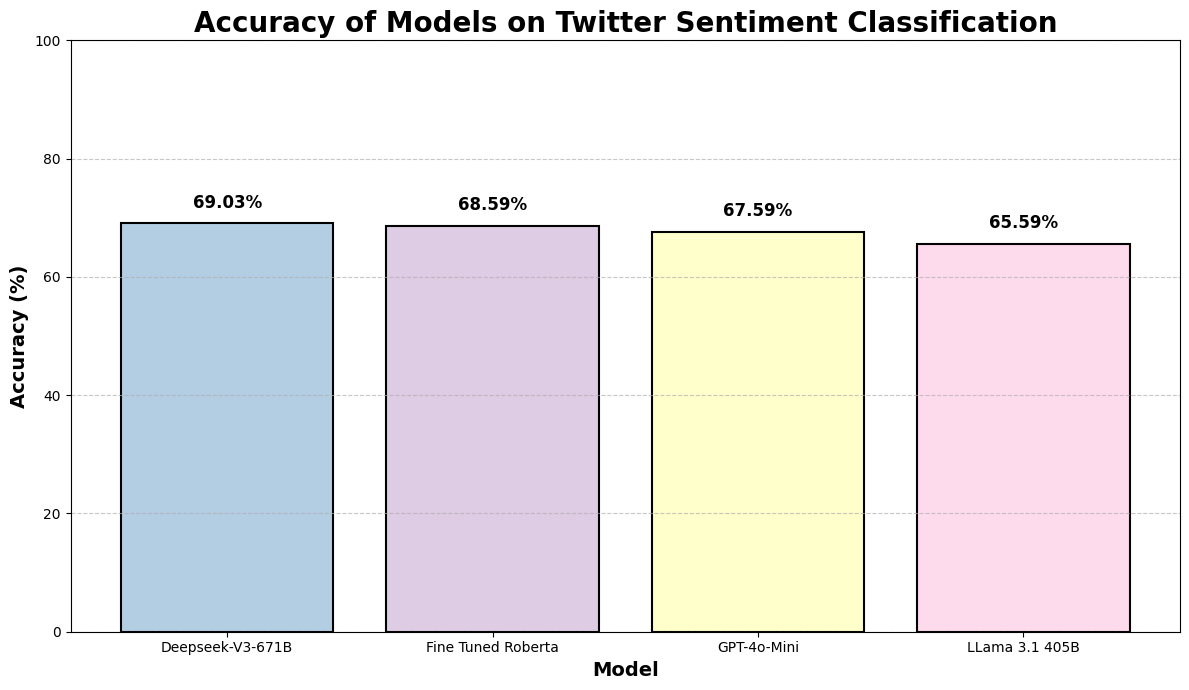

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['LLama 3.1 405B', 'GPT-4o-Mini', 'Deepseek-V3-671B', 'Fine Tuned Roberta']
accuracies = [llama31_405B_accuracy, gpt4omini_accuracy, Deepseek_V3_671B_accuracy, ft_roberta]

# Convert accuracies to percentages
percentages = [acc * 100 for acc in accuracies]

# Combine models and percentages into a list of tuples, sort by accuracy in descending order
sorted_data = sorted(zip(models, percentages), key=lambda x: x[1], reverse=True)
sorted_models, sorted_percentages = zip(*sorted_data)

# Create a more stylish bar chart
plt.figure(figsize=(12, 7))

# Use a gradient color for bars
colors = plt.cm.Pastel1(np.linspace(0.2, 0.8, len(sorted_models)))

# Create bars with rounded edges (no 'height' argument)
bars = plt.bar(sorted_models, sorted_percentages, color=colors, edgecolor='black', linewidth=1.5)

# Title with a bold font style
plt.title("Accuracy of Models on Twitter Sentiment Classification", fontsize=20, fontweight='bold')

# Labels with increased font size and bold style
plt.xlabel("Model", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy (%)", fontsize=14, fontweight='bold')

# Y-axis range from 0 to 100%
plt.ylim(0, 100)

# Add value labels on top of each bar with adjusted style
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2,  # Added a little spacing from the bar
             f'{height:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Customize the grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust the layout for better fitting
plt.tight_layout()

# Show the plot
plt.show()


Roughly the same performance at **0.03%** the size!

### Count of Sentiments

Also interesting to consider the distribution of sentiment labels across these models

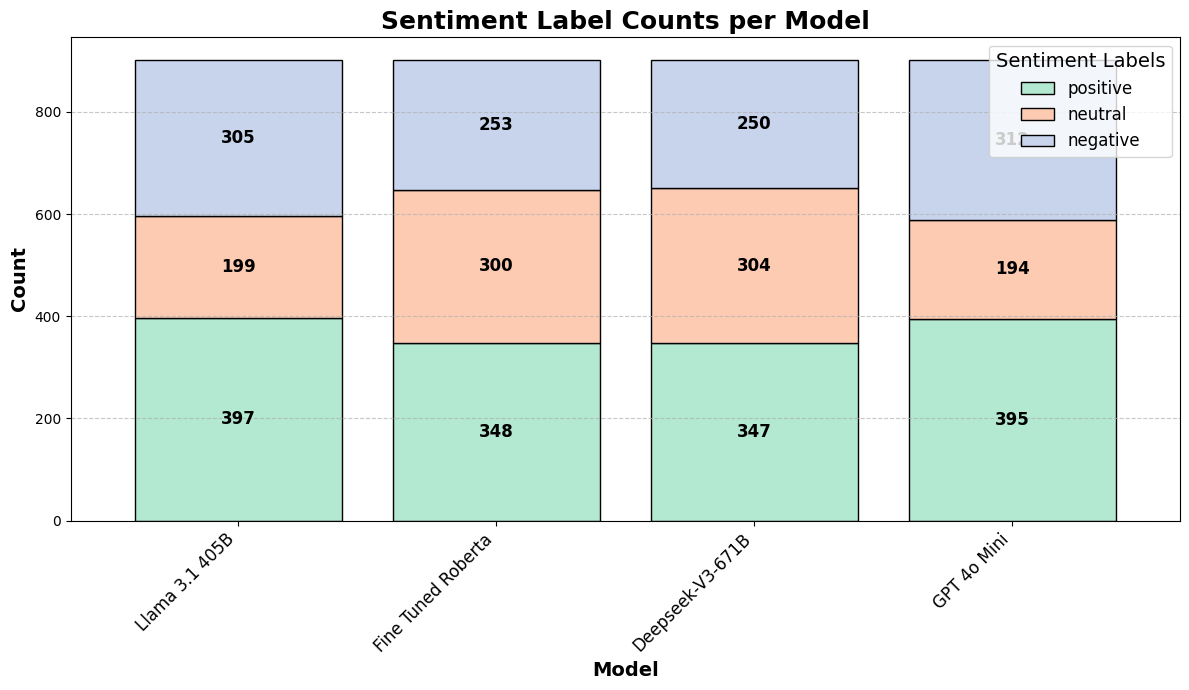

In [103]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# List of models and their corresponding label columns
models = {
    'Llama 3.1 405B': 'Llama_405B_label_text',
    'Fine Tuned Roberta': 'FT_Roberta',
    'Deepseek-V3-671B': 'Deepseek_V3_label_text',
    'GPT 4o Mini': 'GPT4o_mini_label'
}

# Sample result_df creation (replace with actual DataFrame)
# result_df = pd.DataFrame(...)

# Calculating counts
label_counts = {model: {'positive': 0, 'neutral': 0, 'negative': 0} for model in models.keys()}
for model, column in models.items():
    label_counts[model]['positive'] = result_df[result_df[column] == 'positive'].shape[0]
    label_counts[model]['neutral'] = result_df[result_df[column] == 'neutral'].shape[0]
    label_counts[model]['negative'] = result_df[result_df[column] == 'negative'].shape[0]

# Create a DataFrame for plotting
counts_df = pd.DataFrame(label_counts).T

# Plotting with outlines
ax = counts_df.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    color=['#b3e8d1', '#fccbb2', '#c7d4eb'],  # Soft pastel colors
    edgecolor='black',  # Sharp bar edges for contrast
    width=0.8  # Slightly wider bars
)

# Add counts on the bars with a more visible style
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width/2,
            y + height/2,
            f'{int(height)}',
            ha='center',
            va='center',
            fontsize=12,
            fontweight='bold',
            color='black')

# Title and labels with a more dynamic design
plt.title('Sentiment Label Counts per Model', fontsize=18, fontweight='bold')
plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='medium')  # Tilt labels for better readability

# Add a legend with a clean font style
plt.legend(title='Sentiment Labels', fontsize=12, title_fontsize=14)

# Customize grid for better clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


---
# Addtional Notes:

consider the time cost too! Much slower inference with the foundational models compared to the distilled language model.

Note that we are not aiming for higher accuracy here, rather a standard metric to assess our fine tuned model to see if it performs now as well as the foundation model

And a big shoutout to Moritz Laurer for the https://huggingface.co/blog/synthetic-data-save-costs blog, much of which the primary methodology that guided this notebook was heavily inspired by.